# Tweet Sentiment Extraction

From Kaggle:


"My ridiculous dog is amazing." [sentiment: positive]

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import transformers
import tokenizers
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/bert-base-uncased-huggingface-transformer/bert-base-uncased-tf_model.h5
/kaggle/input/bert-base-uncased-huggingface-transformer/bert-base-uncased-vocab.txt


In [2]:
print(tf.__version__)

2.1.0


In [3]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
sample_sub = pd.read_csv('../input/tweet-sentiment-extraction/sample_submission.csv')

In [4]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [6]:
#print(train.dtypes)
train['textID'] = train['textID'].apply(str)
train['text'] = train['text'].apply(str)
train['selected_text'] = train['selected_text'].apply(str)
train['sentiment'] = train['sentiment'].apply(str)

test['textID'] = test['textID'].apply(str)
test['text'] = test['text'].apply(str)
test['sentiment'] = test['sentiment'].apply(str)

#### What is the task?

- Given the tweet text and the sentiment of the tweet, the task at hand is to extract the text from the tweet that reflects the sentiment.
- One can formulate the problem as a question-answering task, where the sentiment is the *(short)* question, the tweet itself is the context and the selected text is the answer.

In [7]:
ex = train.loc[3,:]
context = ex.text
answer = ex.selected_text
print(context)
print(answer)

 what interview! leave me alone
leave me alone


- Notice the extra space at the beginning of the context string.

In [8]:
train.sentiment.value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

- Most of the sentiments are neutral!

In [9]:
train.loc[train.sentiment == 'neutral',['text', 'selected_text']].apply(lambda row: len(row['text'].strip())-
                                                                        len(row['selected_text'].strip()), axis=1 ).value_counts().head(10)

0     10005
1       171
2       116
3        66
27       57
26       39
5        38
8        37
4        37
6        35
dtype: int64

- What you notice above is the fact that for most of the neutral sentiments, the selected text (answer) is the same as the text/tweet (context). This is in line with what you'd expect. 

In [10]:


BERT_PATH = '../input/bert-base-uncased-huggingface-transformer/'
# Intialize the BERT base uncased tokenizer
tokenizer = tokenizers.BertWordPieceTokenizer(BERT_PATH+'bert-base-uncased-vocab.txt')

def preprocess_input_data(question, context, answer, tokenizer, max_len):
    
# Tokenize and encode the question (sentiment) and the context (tweet) with special tokens
    enc = tokenizer.encode(question,context)
    input_ids = enc.ids   
    input_tokens = enc.tokens
    token_type_ids = enc.type_ids # These are the segment ids for differentiating question from context
    attention_mask = enc.attention_mask
    offsets = enc.offsets
    
    target_char_start  = context.find(answer)
    target_char_end = target_char_start + len(answer) - 1
    char_targets = [0]*len(context)
    for i in range(target_char_start,target_char_end+1):
        char_targets[i] = 1
    
    targets_index_context = []
    
    offsets_context = offsets[3:-1]
    for ind, (i,j) in enumerate(offsets_context):
        if sum(char_targets[i:j]) > 0:
            targets_index_context.append(ind) 
           
    target_start_ind = targets_index_context[0] 
    target_end_ind   = targets_index_context[-1]
    
    target_start_ind += 3
    target_end_ind += 3
    
    # padding -- pad the vectors if their lengths exceed max_len, else truncate at max_len
    pad_len = max_len - len(token_type_ids)
    if(pad_len> 0):
        token_type_ids = token_type_ids + [0]*pad_len
        input_ids = input_ids + [0]*pad_len
        attention_mask = attention_mask + [0]*pad_len
        offsets = offsets + [(0,0)]*pad_len    
    else:
        token_type_ids = token_type_ids[:max_len]
        input_ids = input_ids[:max_len]
        attention_mask = attention_mask[:max_len]
        offsets = offsets[:max_len]

    
    output_dict = {'token_type_ids': token_type_ids,
                  'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'target_start': target_start_ind,
                  'target_end': target_end_ind,
                  'input_tokens': input_tokens,
                   'offsets': offsets,
                   'attention_mask': attention_mask,
                   'sentiment': question,
                   'context': context,
                   'answer': answer
                  }
    return output_dict

In [11]:
data_example = preprocess_input_data(train.sentiment[3], train.text[3], train.selected_text[3], tokenizer, max_len = 15)
print('Sentiment: ',data_example['sentiment'])
print('Tweet: ',data_example['context'])
print('Selected text: ',data_example['answer'])
print('Input tokens: ',data_example['input_tokens'])
print('Token type ids: ', data_example['token_type_ids'])
print('Input_ids: ',data_example['input_ids'])
print('Target start index: {}, Target end index: {}'.format(data_example['target_start'], data_example['target_end']))
print('Attention mask: ', data_example['attention_mask'])
print('Offsets: ',data_example['offsets'])

Sentiment:  negative
Tweet:   what interview! leave me alone
Selected text:  leave me alone
Input tokens:  ['[CLS]', 'negative', '[SEP]', 'what', 'interview', '!', 'leave', 'me', 'alone', '[SEP]']
Token type ids:  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Input_ids:  [101, 4997, 102, 2054, 4357, 999, 2681, 2033, 2894, 102, 0, 0, 0, 0, 0]
Target start index: 6, Target end index: 8
Attention mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Offsets:  [(0, 0), (0, 8), (0, 0), (1, 5), (6, 15), (15, 16), (17, 22), (23, 25), (26, 31), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


112


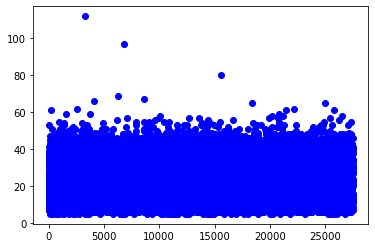

In [12]:
len_tokens = []
for i in range(train.shape[0]):
    question = train.sentiment[i]
    context= train.text[i]
    enc = tokenizer.encode(question,context)
    input_ids = enc.ids  
    len_tokens.append(len(input_ids))

print(max(len_tokens))
plt.plot(np.arange(len(len_tokens)), len_tokens, 'bo');

In [13]:
max_len = 128


input_ids = np.zeros((train.shape[0],max_len))
token_type_ids = np.zeros((train.shape[0],max_len))
attention_mask = np.zeros((train.shape[0],max_len))
start_ids = np.zeros((train.shape[0],max_len))
end_ids = np.zeros((train.shape[0],max_len))


for i in range(train.shape[0]):
    question = train.sentiment[i]
    context= train.text[i]
    answer = train.selected_text[i]
    processed_data = preprocess_input_data(question, context, answer, tokenizer, max_len = max_len)
    input_ids[i,:] = processed_data['input_ids']
    token_type_ids[i,:] = processed_data['token_type_ids']
    attention_mask[i,:] = processed_data['attention_mask']
    start_ids[i,:] = to_categorical(processed_data['target_start'], num_classes = max_len)
    end_ids[i,:] = to_categorical(processed_data['target_end'], num_classes = max_len)

In [14]:


def preprocess_test_data(question, context, tokenizer, max_len):
    
# Tokenize and encode the question (sentiment) and the context (tweet) with special tokens
    enc = tokenizer.encode(question,context)
    input_ids = enc.ids   
    input_tokens = enc.tokens
    token_type_ids = enc.type_ids # These are the segment ids for differentiating question from context
    attention_mask = enc.attention_mask
    offsets = enc.offsets
    
    
    # padding -- pad the vectors if their lengths exceed max_len, else truncate at max_len
    pad_len = max_len - len(token_type_ids)
    if(pad_len> 0):
        token_type_ids = token_type_ids + [0]*pad_len
        input_ids = input_ids + [0]*pad_len
        attention_mask = attention_mask + [0]*pad_len
        offsets = offsets + [(0,0)]*pad_len    
    else:
        token_type_ids = token_type_ids[:max_len]
        input_ids = input_ids[:max_len]
        attention_mask = attention_mask[:max_len]
        offsets = offsets[:max_len]

    
    output_dict = {'token_type_ids': token_type_ids,
                  'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'input_tokens': input_tokens,
                   'offsets': offsets,
                   'attention_mask': attention_mask,
                   'sentiment': question,
                   'context': context,
                  }
    return output_dict

input_ids_test = np.zeros((test.shape[0],max_len))
token_type_ids_test = np.zeros((test.shape[0],max_len))
attention_mask_test = np.zeros((test.shape[0],max_len))


for i in range(test.shape[0]):
    question = test.sentiment[i]
    context= test.text[i]
    processed_data_test = preprocess_test_data(question, context, tokenizer, max_len = max_len)
    input_ids_test[i,:] = processed_data_test['input_ids']
    token_type_ids_test[i,:] = processed_data_test['token_type_ids']
    attention_mask_test[i,:] = processed_data_test['attention_mask']


## BERT model
- The BERT output (768 dimensional vector for each token) is passed on to a CNN layer followed by a linear layer with softmax activation. The linear layer equivalent to a 1-convolution in the context of NLP (or 1x1 convolution in vision). The output of this head represents the  probability of a token being the start index of the answer. Similarly, we construct another head for the end index.
- Dropout is added right after BERT embedding layer for regularization.
- The model is inspired by Chris Deotte's awesome kernel [here](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705/).

In [15]:
#    config = transformers.BertConfig()

def build_model():
    ids = tf.keras.layers.Input((max_len,), dtype=tf.int32)
    tok = tf.keras.layers.Input((max_len,), dtype=tf.int32)
    att = tf.keras.layers.Input((max_len,), dtype=tf.int32)
    
    config = transformers.BertConfig()
    bert_tf = transformers.TFBertModel.from_pretrained(BERT_PATH+'bert-base-uncased-tf_model.h5', config=config)
    x = bert_tf({'input_ids': ids, 'token_type_ids': tok, 'attention_mask': att})[0]

 # Refer to https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf   

#    print(x.shape)
    
    h1 = tf.keras.layers.Dropout(0.1)(x) 
    h1 = tf.keras.layers.Conv1D(128, 2,padding='same')(h1)
    h1 = tf.keras.layers.BatchNormalization()(h1)
    h1 = tf.keras.layers.ReLU()(h1)
    h1 = tf.keras.layers.Dense(1)(h1)
    h1 = tf.keras.layers.Flatten()(h1)
    h1 = tf.keras.layers.Activation('softmax')(h1)

    h2 = tf.keras.layers.Dropout(0.1)(x) 
    h2 = tf.keras.layers.Conv1D(128, 2,padding='same')(h2)
    h2 = tf.keras.layers.BatchNormalization()(h2)
    h2 = tf.keras.layers.ReLU()(h2)
    h2 = tf.keras.layers.Dense(1)(h2)
    h2 = tf.keras.layers.Flatten()(h2)
    h2 = tf.keras.layers.Activation('softmax')(h2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[h1,h2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=4e-5)
    model.compile(optimizer = optimizer, loss='categorical_crossentropy')

    return model


In [16]:
model = build_model()

# Let's take a look at the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 109482240   input_3[0][0]                    
                                                                 input_1[0][0]                

In [17]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [18]:
def train_model(input_ids, attention_mask, token_type_ids, input_ids_test,attention_mask_test,token_type_ids_test,kfold_n_splits = 5, epochs=3):
  jaccard_scores = []
  oof_start = np.zeros((input_ids.shape[0],max_len))
  oof_end = np.zeros((input_ids.shape[0],max_len))
  preds_start = np.zeros((input_ids_test.shape[0],max_len))
  preds_end = np.zeros((input_ids_test.shape[0],max_len))

  skf = StratifiedKFold(n_splits=kfold_n_splits,shuffle=True,random_state=1212)
  for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD {}'.format(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
#    sv = tf.keras.callbacks.ModelCheckpoint(
#        "bert-fold{}.h5".format(fold+1), monitor='val_loss', verbose=1, save_best_only=True,
#        save_weights_only=True, mode='auto', save_freq='epoch')
        
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]],
              [start_ids[idxT,], end_ids[idxT,]], 
              epochs=epochs, batch_size=16, verbose=1, #callbacks=[sv],
              validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
                               [start_ids[idxV,], end_ids[idxV,]]))
    
#    print('Loading model...')
#    model.load_weights('bert-fold%i.h5'%(fold))
#    shutil.copy2(r'bert-fold{}.h5'.format(fold+1), r'/content/gdrive/My Drive/')

    print('Predicting out-of-fold answer span')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=1)
      
    # DISPLAY FOLD JACCARD
    jac_oof = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        true_answer = train.loc[k,'selected_text']
        if (train.loc[k, 'sentiment'] == 'neutral'):
            pred_answer = train.loc[k, 'text']
            pred_answer = pred_answer.strip() 
        elif a>b: 
            encoding = tokenizer.encode(train.loc[k, 'sentiment'], train.loc[k,'text'])
            pred_answer = tokenizer.decode(encoding.ids[a:-1]) 
            pred_answer = pred_answer.strip() 
        else:
            encoding = tokenizer.encode(train.loc[k, 'sentiment'], train.loc[k,'text'])
            pred_answer = tokenizer.decode(encoding.ids[a:b+1]) 
            pred_answer = pred_answer.strip() 
        jac_oof.append(jaccard(pred_answer, true_answer))
    jaccard_scores.append(np.mean(jac_oof))
    print('FOLD %i Jaccard ='%(fold+1),np.mean(jac_oof))

    print('Predicting Test answer span')
    preds = model.predict([input_ids_test,attention_mask_test,token_type_ids_test])
    preds_start += preds[0]/kfold_n_splits
    preds_end += preds[1]/kfold_n_splits
  return {'pred_test_start': preds_start, 'pred_test_end': preds_end,
          'jaccard_kfold': jaccard_scores}


In [19]:
out = train_model(input_ids, attention_mask, token_type_ids, input_ids_test,attention_mask_test,token_type_ids_test,kfold_n_splits = 5, epochs=3)

#########################
### FOLD 1
#########################
Train on 21984 samples, validate on 5497 samples
Epoch 1/3
21984/21984 [==============================] - 393s 18ms/sample - loss: 2.0160 - activation_loss: 1.0067 - activation_1_loss: 1.0093 - val_loss: 1.7305 - val_activation_loss: 0.8770 - val_activation_1_loss: 0.8530
Epoch 2/3
21984/21984 [==============================] - 376s 17ms/sample - loss: 1.5454 - activation_loss: 0.7749 - activation_1_loss: 0.7705 - val_loss: 1.7654 - val_activation_loss: 0.8815 - val_activation_1_loss: 0.8833
Epoch 3/3
21984/21984 [==============================] - 376s 17ms/sample - loss: 1.1698 - activation_loss: 0.5910 - activation_1_loss: 0.5788 - val_loss: 2.1107 - val_activation_loss: 1.0430 - val_activation_1_loss: 1.0667
Predicting out-of-fold answer span
5497/5497 [==============================] - 33s 6ms/sample
FOLD 1 Jaccard = 0.6675426273561148
Predicting Test answer span
#########################
### FOLD 2
####################

In [20]:
print('Mean Jaccard (CV): {}'.format(np.mean(out_inf['jaccard_kfold'])))

NameError: name 'out_inf' is not defined

In [21]:
sample_sub.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [22]:
# predict on the test set

preds_start, preds_end = out['pred_test_start'], out['pred_test_end']
for i in range(input_ids_test.shape[0]):
    a = np.argmax(preds_start[i,])
    b = np.argmax(preds_end[i,])
    if (test.loc[i, 'sentiment'] == 'neutral'):
        pred_answer = test.loc[i, 'text']
        test.loc[i,'selected_text'] = pred_answer
        pred_answer = pred_answer.strip() 
    elif a>b:
        encoding = tokenizer.encode(test.loc[i, 'sentiment'], test.loc[i,'text'])
        pred_answer = tokenizer.decode(encoding.ids[a:-1])  
        test.loc[i,'selected_text'] = pred_answer
        pred_answer = pred_answer.strip() 
    else:
        encoding = tokenizer.encode(test.loc[i, 'sentiment'], test.loc[i,'text'])
        pred_answer = tokenizer.decode(encoding.ids[a:b+1])  
        test.loc[i,'selected_text'] = pred_answer
        pred_answer = pred_answer.strip() 

- Only *textID* and *selected_text* need to be saved in submission file.

In [23]:
test.head(30)

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,such a shame!
3,01082688c6,happy bday!,positive,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like it!!
5,726e501993,that`s great!! weee!! visitors!,positive,that ` s great!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,hates
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,completely blocked
8,e64208b4ef,and within a short time of the last clue all ...,neutral,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,What did you get? My day is alright.. haven`...


In [24]:
test[['textID', 'selected_text']].to_csv('submission.csv',index=False)